## Notebook for OCEANS'19 Seattle conference paper
## _Tensor decomposition of multi-frequency echosounder time series_

**Authors**: Wu-Jung Lee, Valentina Staneva

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorly as tl

## Load and inspect data

### Calibrated Sv

In [37]:
Sv_raw_path = '/Volumes/wjlee_apl_2/ooi_zplsc_current/'
Sv_raw_fname = '20150817-20151017_Sv.h5'
f_Sv = h5py.File(os.path.join(Sv_raw_path,Sv_raw_fname),'r')

In [38]:
ping_time_Sv = np.array(f_Sv['ping_time'])

In [43]:
print('There are a total of %d pings per hour.' % (20*60/5))  # Number of pings per hour

There are a total of 240 pings per hour.


### Calibrated MVBS data

Here we first inspect the calibrated mean volume backscattering strength (MVBS, or $\overline{\textrm{S}_\textrm{V}}$) already pre-processed from the raw data.
The raw data were obtained from the Ocean Observatories Initiative (OOI) Raw Data 
Archive, from the Oregon Offshore Cabled Shallow Profiler Mooring (CE04OSPS).
All other info can be found in the paper.

In [13]:
# Set up paths
MVBS_raw_path = '/Users/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_raw_fname = '20150817-20151017_MVBS.h5'
fig_save_path = '/Users/wu-jung/code_git/ooi_sonar/tensor/figs_2019_paper/'

In [14]:
# Load raw MVBS data
f_raw = h5py.File(os.path.join(MVBS_raw_path,MVBS_raw_fname),'r')
MVBS_raw = np.array(f_raw['MVBS'])
depth_bin_size = np.array(f_raw['depth_bin_size'])
ping_time = np.array(f_raw['ping_time'])
# f_raw.close()

In [15]:
from matplotlib.dates import date2num, num2date

In [16]:
num2date(ping_time)

[datetime.datetime(2015, 8, 17, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 3, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 6, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 10, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 13, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 0, 16, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 3, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 6, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 10, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 13, 20, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 1, 16, 40, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 2, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 8, 17, 2, 3, 20, tzinfo=datetime.timezon

Let's first inspect the dimension of the data:

In [71]:
MVBS_raw.shape

(3, 40, 8928)

The first dimension is **frequency** (= 38, 120, and 200 kHz). The second dimension is **range** (or depth) from the echosounder location going upward towards the surface. The third dimension is **ping number**, which includes all pings in the selected date range collected by the echosounder. The MVBS data were obtained from the calibrated volume backscattering strength $\textrm{S}_\textrm{V}$ by averaging over every 40 pings and 5 m of data. The echosounder was set to transmit every 5 seconds for the first 20 minutes of each hour. Therefore by averaging every 40 pings, the MVBS data contains 6 tiles per hour, with a total of 144 tiles per day.

When plotting the data, note that we inverted the second dimension (depth), because the sonar was upward-looking from an underwater platform, and the echo time series was recorded from the source location. We only plot the first 37 depth bins because the last 3 bins contains very strong scattering from the sea surface that can dominate the decomposition. The surface scattering also include signatures from the tidal cycles that have a different periodicity than the daylight cycles on which our decomposition is structured.

In [85]:
def plot_3_echograms(echoes,cpd,dnum,dspace):
    """Plot a stack of 3 echograms.
    
    echoes   data to be plotted
    cpd      chunk per day
    dnum     number of days
    dspace   spacing between day ticks
    """
    fig,ax = plt.subplots(3,1,figsize=(16,5),sharex=True)
    plt.subplots_adjust(hspace=0.15)
    for f in range(3):
        im = ax[f].imshow(echoes[f],
                     aspect='auto', vmin=-80, vmax=-40, cmap='Spectral_r')
        ax[f].set_xticks(range(0,dnum*cpd,cpd*dspace))
        ax[f].set_xticklabels(range(0,dnum,dspace))
        ax[f].set_yticks(range(0,37,18))
        ax[f].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
        plt.setp(ax[f].get_xticklabels(), fontsize=13)
        plt.setp(ax[f].get_yticklabels(), fontsize=13)
        if ax[f].is_last_row():
            plt.xlabel('Day of observation',fontsize=16)
        if f==1:
            ax[f].set_ylabel('Depth (m)',fontsize=16)

    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.12, 0.01, 0.76])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks(np.arange(-80, -39, 10))

    return fig

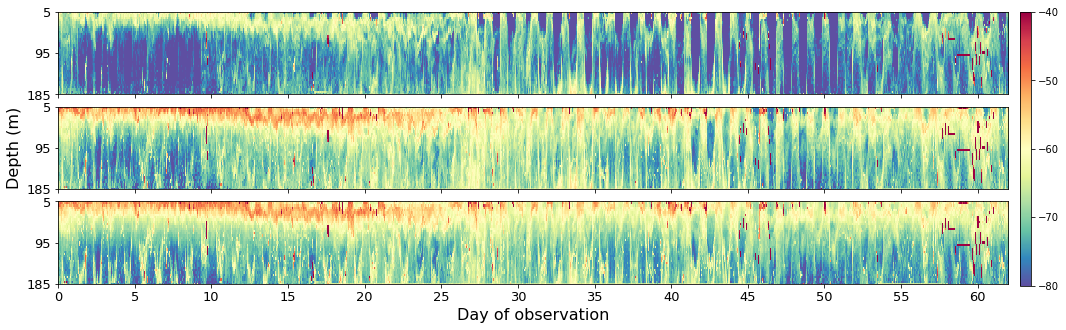

In [88]:
# Calibrated MVBS over selected data period
echoes_mvbs = []
for f in range(3):
    echoes_mvbs.append(MVBS_raw[f,37:0:-1,:])
    
fig = plot_3_echograms(echoes_mvbs,
                       cpd=144,dnum=65,dspace=5)

### MVBS cleaned using PCP

Seeing the many noisy echo patches in the original calibrated MVBS data, we employed Principal Component Pursuit (PCP) to separate the noisy component from the low-rank component before applying tensor decomposition. PCP takes some time to run, so here we will proceed by loading the low-rank component from PCP that has been calculated elsewhere.

In [74]:
# Load PCP-cleaned MVBS data
MVBS_pcp_path = MVBS_raw_path
MVBS_pcp_fname = '20150817-20151017_MVBS_PCPcleaned.h5'
f_pcp = h5py.File(os.path.join(MVBS_pcp_path,MVBS_pcp_fname),'r')

# Load only low-rank data
L = np.array(f_pcp['L'])
L_sep = np.array(f_pcp['L_sep'])
depth_bin_size = np.array(f_pcp['depth_bin_size'])
ping_per_day_mvbs = np.array(f_pcp['ping_per_day_mvbs'])
ping_time = np.array(f_pcp['ping_time'])
f_pcp.close()

The low-rank data is organized with dimension `frequency` x `number of days` x `depth` x `number of observations within day`.

In [75]:
L_sep.shape

(3, 62, 37, 144)

Below we plot the low-rank data to compare with the original MVBS before PCP processing.

Let's first do some reshaping of the low-rank data matrix to make sure we can plot properly using the `plot_3_echograms` function.

In [89]:
echoes_low_rank = []
for f in range(3):
    echoes_low_rank.append(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:])

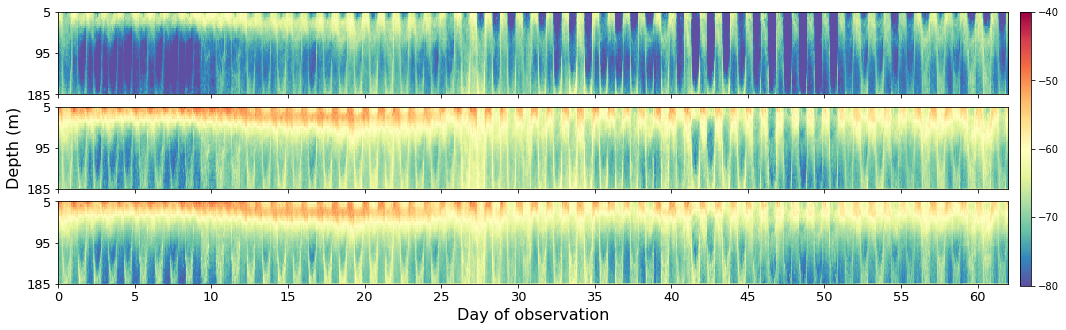

In [90]:
fig = plot_3_echograms(echoes_low_rank,
                       cpd=144,dnum=65,dspace=5)

### Data decimation

After some trial-and-error, we found out that tensor decomposition takes quite a bit of memory and that we can more efficiently run the decomposition by decimating the low-rank data by averaging 6 tiles of MVBS data, which effectively reduce the data to 1 observation per hour for each depth bin.

In [47]:
# Average across time of day columns
tod_num = 6
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [48]:
L_sep_reduce.shape

(3, 62, 37, 24)

On the grand scale the decimated data look very similar to without averaging over the pings:

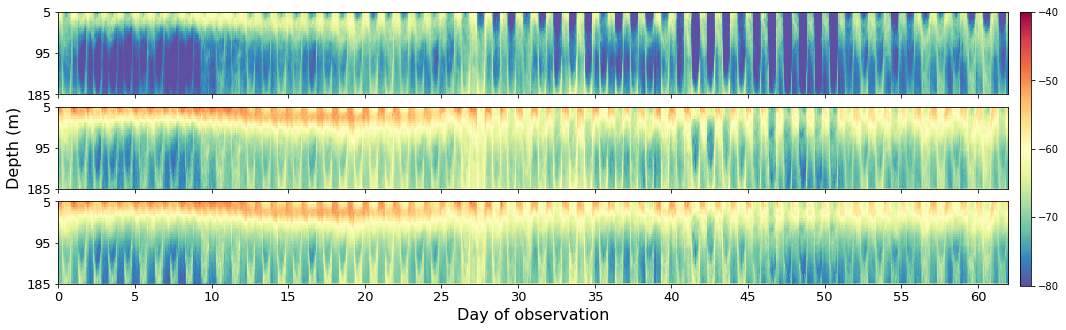

In [91]:
echoes_low_rank_reduce = []
for f in range(3):
    echoes_low_rank_reduce.append(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank_reduce,
                       cpd=24,dnum=65,dspace=5)

But obviously the effects of decimation are much more prominent when you look at only a smaller number of days:

First we look at the original MVBS data for the first 10 days:

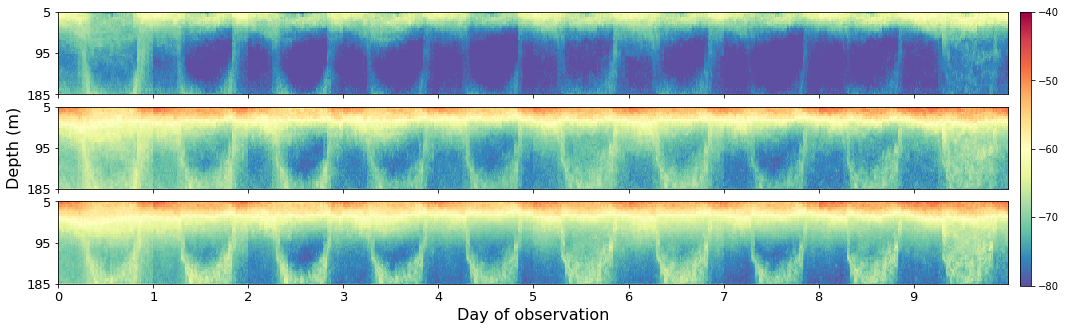

In [96]:
echoes_low_rank_10days = []
for f in range(3):
    echoes_low_rank_10days.append(tl.unfold(tl.tensor(L_sep[f,:10,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank_10days,
                       cpd=144,dnum=10,dspace=1)

And when we compare it with the decimated data:

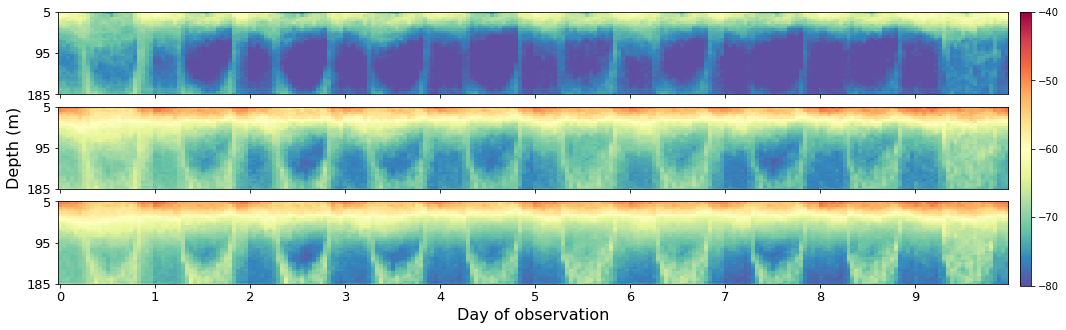

In [94]:
echoes_low_rank_reduce_10days = []
for f in range(3):
    echoes_low_rank_reduce_10days.append(tl.unfold(tl.tensor(L_sep_reduce[f,:10,:,:].squeeze()),mode=1)[::-1,:])

fig = plot_3_echograms(echoes_low_rank_reduce_10days,
                       cpd=24,dnum=10,dspace=1)

The basic features of the echograms are preserved in the decimated data, but the effects of quantization is also clearly visible.

## Reshaping to form tensor with daily ping-by-ping observations stacked together

In [100]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [101]:
L_sep_reduce_reshape = L_sep_reduce.reshape((3,62,37*24))

Plotting out to check how the unfolded reshaped matrix looks like:

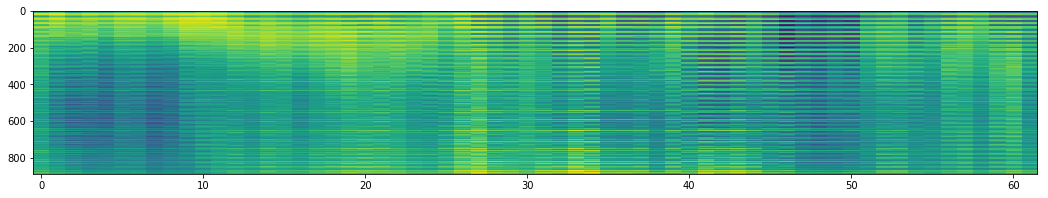

In [105]:
fig = plt.figure(figsize=(18,3))
plt.imshow(tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)[::-1,:],
           aspect='auto',cmap='viridis')
plt.show()

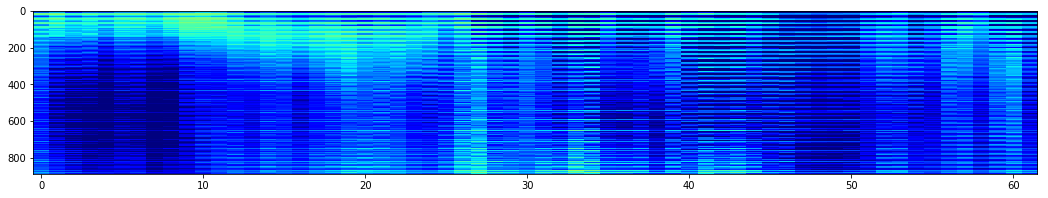

In [103]:
fig = plt.figure(figsize=(18,3))
plt.imshow(tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)[::-1,:],
           aspect='auto',vmin=-80,vmax=-40,cmap='jet')
plt.show()

In [15]:
37*24

888

In [107]:
A = tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)
A.shape

(888, 62)

Making sure I am getting the reshaping right by trying to reconstruct the first day at 3 frequencies:

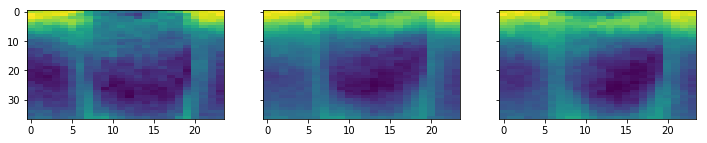

In [118]:
fig,ax = plt.subplots(1,3,figsize=(12,2),sharey=True)
for f in range(3):
    ax[f].imshow(A[:,f].reshape((37,24))[::-1,:],aspect='auto')
plt.show()

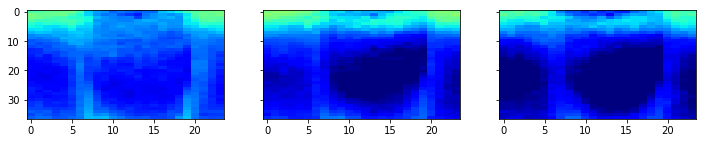

In [109]:
# Try to plot in jet
fig,ax = plt.subplots(1,3,figsize=(12,2),sharey=True)
for f in range(3):
    ax[f].imshow(A[:,f].reshape((37,24))[::-1,:],aspect='auto',vmin=-80,vmax=-40,cmap='jet')
plt.show()

I am doing the reshaping to combine the depth and hour dimension, because for parafac, it is not possible for a single component to capture the DVM, since that type of pattern is not possible for an outer product of two vectors. Under this constraint I think it makes more sense to go back to treating the echograms as images as done when using NMF, but here we could throw in data from different frequencies along one dimension instead of concatenating them together.

With the above confirmation now we define the sonar tensor:

In [110]:
sonar_tensor = tl.tensor(L_sep_reduce_reshape)

In [111]:
sonar_tensor.shape

(3, 62, 888)

# Try parafac decomposition

Before in 2018-10-29 notebook was trying to do parafac decomposition of data from 1 frequency. Now try to see if can run 4D decomposition with frequency being one of the dimensions.

In [119]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac, non_negative_parafac
from tensorly.tenalg import kronecker, khatri_rao

### Rank=3

In [124]:
kruskal_rank = 3
factors_kruskal_3 = parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)
factors_kruskal_nonneg_3 = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)

In [125]:
[factors_kruskal_nonneg_3[f].shape for f in range(len(factors_kruskal_nonneg_3))]

[(3, 3), (62, 3), (888, 3)]

In [126]:
full_tensor_3 = tl.kruskal_to_tensor(factors_kruskal_3)
full_tensor_nonneg_3 = tl.kruskal_to_tensor(factors_kruskal_nonneg_3)

In [127]:
full_tensor_3.shape

(3, 62, 888)

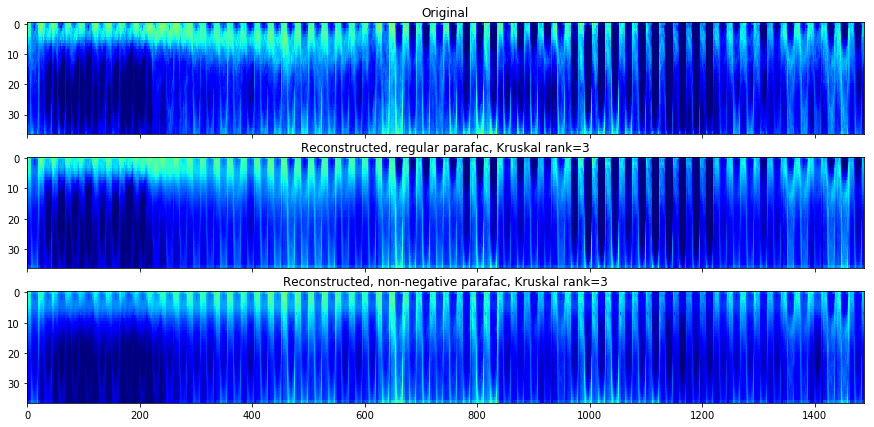

In [129]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:,:].reshape((62,37,24))).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-40, vmin=-80,cmap='jet')
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,:,:].reshape((62,37,24))).squeeze()+sonar_tensor.min(), mode=1)[::-1,:],
             aspect='auto',vmax=-40, vmin=-80,cmap='jet')
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:,:].reshape((62,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-40, vmin=-80,cmap='jet')
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

## Checking non-negative parafac results

In [134]:
sonar_tensor.shape

(3, 62, 888)

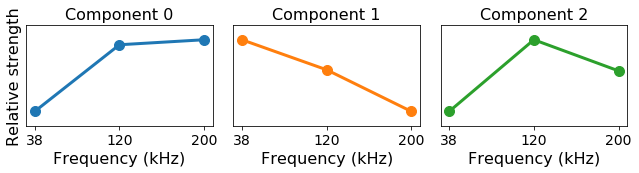

In [181]:
fig,ax = plt.subplots(1,3,figsize=(9,2.5))
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[0][:,i],'o-',linewidth=3,markersize=10,color='C%d'%i)
    ax[i].set_title('Component %d'% i, fontsize=16)
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels([38,120,200], fontsize=14)
    ax[i].set_xlabel('Frequency (kHz)', fontsize=16)
    ax[i].set_yticks([])
    ax[i].set_yticklabels('', fontsize=14)
    if ax[i].is_first_col():
        ax[i].set_ylabel('Relative strength', fontsize=16)
    yrange = factors_kruskal_nonneg_3[0][:,i].max()-factors_kruskal_nonneg_3[0][:,i].min()
    ax[i].set_ylim(factors_kruskal_nonneg_3[0][:,i].min()-yrange*0.2,
                   factors_kruskal_nonneg_3[0][:,i].max()+yrange*0.2)
plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor',
                         'dim_freq.png'),dpi=150)
plt.show()

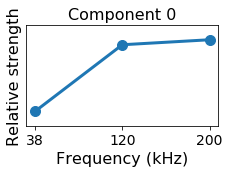

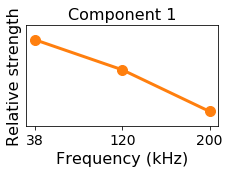

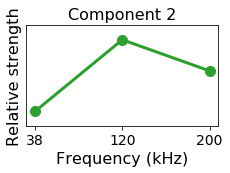

In [209]:
for i in range(3):
    plt.figure(figsize=(3.3,2.5))
    plt.plot(factors_kruskal_nonneg_3[0][:,i],'o-',linewidth=3,markersize=10,color='C%d'%i)
    plt.title('Component %d'% i, fontsize=16)
    plt.xticks(np.arange(3), [38,120,200], fontsize=14)
    plt.yticks([], '', fontsize=14)
    plt.xlabel('Frequency (kHz)', fontsize=16)
    plt.ylabel('Relative strength', fontsize=16)
    plt.tight_layout()
    yrange = factors_kruskal_nonneg_3[0][:,i].max()-factors_kruskal_nonneg_3[0][:,i].min()
    plt.ylim(factors_kruskal_nonneg_3[0][:,i].min()-yrange*0.2,
             factors_kruskal_nonneg_3[0][:,i].max()+yrange*0.2)
    plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor',
                             'dim_freq_%d.png'%i),dpi=150)
    plt.show()

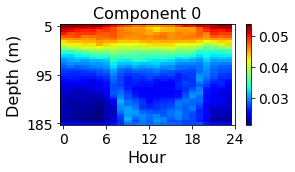

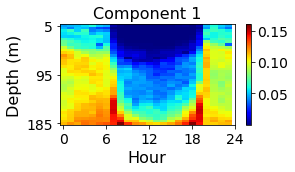

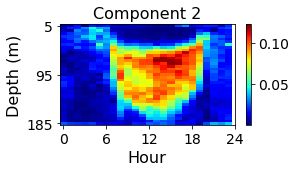

In [199]:
for i in range(3):
    plt.figure(figsize=(4.2,2.5))
    plt.imshow(factors_kruskal_nonneg_3[2][:,i].reshape((37,24))[::-1,:],aspect='auto',cmap='jet')
    plt.title('Component %d'% i, fontsize=16)
    plt.xticks(np.arange(0,25,6), fontsize=14)
    plt.yticks(range(0,37,18), (np.arange(0,37,18)+1)*depth_bin_size, fontsize=14)
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Depth (m)', fontsize=16)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14) 
    plt.tight_layout()
    plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor',
                             'dim_dailyimg_%d.png'%i),dpi=150)
    plt.show()

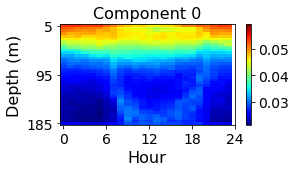

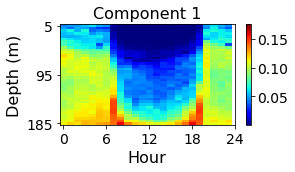

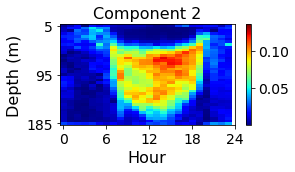

In [212]:
for i in range(3):
    plt.figure(figsize=(4.2,2.5))
    zmax = factors_kruskal_nonneg_3[2][:,i].max()
    plt.imshow(factors_kruskal_nonneg_3[2][:,i].reshape((37,24))[::-1,:],aspect='auto',cmap='jet',vmax=zmax*1.1)
    plt.title('Component %d'% i, fontsize=16)
    plt.xticks(np.arange(0,25,6), fontsize=14)
    plt.yticks(range(0,37,18), (np.arange(0,37,18)+1)*depth_bin_size, fontsize=14)
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Depth (m)', fontsize=16)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14) 
    plt.tight_layout()
    plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor',
                             'dim_dailyimg_%d.png'%i),dpi=150)
    plt.show()

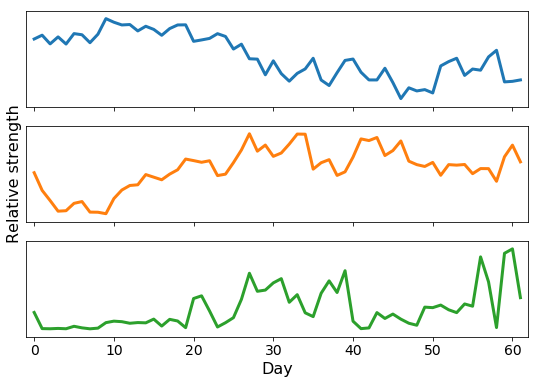

In [242]:
fig,ax = plt.subplots(3,1,figsize=(9,6),sharex=True)
fig.subplots_adjust(hspace=0.2)
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[1][:,i],linewidth=3,markersize=10,color='C%d'%i)
    ax[i].set_xticks(np.arange(0,62,10))
    ax[i].set_xticklabels(np.arange(0,62,10), fontsize=14)
#     ax[i].set_title('Component %d'% i, fontsize=16)
    ax[i].set_yticks([])
    ax[i].set_yticklabels('', fontsize=14)
    if i==1:
        ax[i].set_ylabel('Relative strength', fontsize=16)
    if ax[i].is_last_row():
        ax[i].set_xlabel('Day',fontsize=16)
    yrange = factors_kruskal_nonneg_3[1][:,i].max()-factors_kruskal_nonneg_3[1][:,i].min()
    ax[i].set_ylim(factors_kruskal_nonneg_3[1][:,i].min()-yrange*0.1,
                   factors_kruskal_nonneg_3[1][:,i].max()+yrange*0.1)
    ax[i].set_xlim(-1,62)
# plt.tight_layout()
# plt.show()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor',
                         'dim_day.png'),dpi=150)

## Combine pairs of factors (non-negative parafac)

In [243]:
import itertools

In [244]:
# Khatri-kao product to combine the factors
kr_nn_patterns = []
kr_nn_combs = []
for x,y in itertools.combinations(range(3),2):
    kr_nn_patterns.append((x,y))
    kr_nn_combs.append(khatri_rao((factors_kruskal_nonneg_3[x],factors_kruskal_nonneg_3[y])))

In [245]:
sonar_tensor.shape

(3, 62, 888)

In [246]:
kr_nn_patterns

[(0, 1), (0, 2), (1, 2)]

In [247]:
[x.shape for x in kr_nn_combs]

[(186, 3), (2664, 3), (55056, 3)]

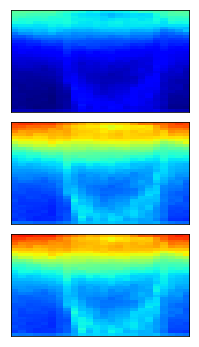

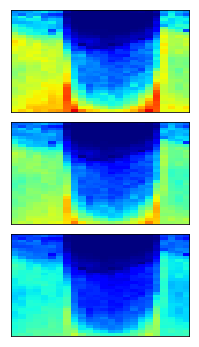

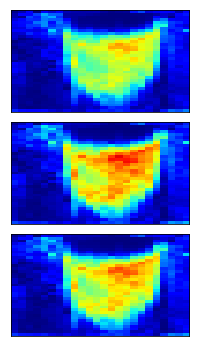

In [318]:
for fac in range(3):
    fig,ax = plt.subplots(3,1,figsize=(3.2,6),sharex=True)
    plt.subplots_adjust(hspace=0.1)
    tmp = tl.unfold(tl.tensor(kr_nn_combs[1][:,fac].reshape(3,37,24)[:,::-1,:]),mode=2).T
    zmax = tmp.max()
    zmin = tmp.min()
    for freq in range(3):
        ax[freq].imshow(tmp[freq*37+np.arange(0,37,1),:],aspect='auto',
                        vmax=zmax*1.1, vmin=zmin, cmap='jet')
        ax[freq].set_xticks([])
        ax[freq].set_yticks([])
#         ax[freq].set_xticks(np.arange(0,25,6))
#         ax[freq].set_xticklabels(np.arange(0,25,6), fontsize=14)
#         ax[freq].set_yticks(np.arange(0,37,18))
#         ax[freq].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size, fontsize=14)
#         if freq==1:
#             ax[freq].set_ylabel('Depth (m)', fontsize=16)
#         if freq==2:
#             ax[freq].set_xlabel('Hour', fontsize=16)
#         ax[freq].set_xlim(0,24)
    plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor',
                             'combine_dim_freq_dailyimg_%d.png'%fac),dpi=150)
    plt.show()

## Reconstructing data at 120 kHz

### Raw MVBS at 120 kHz

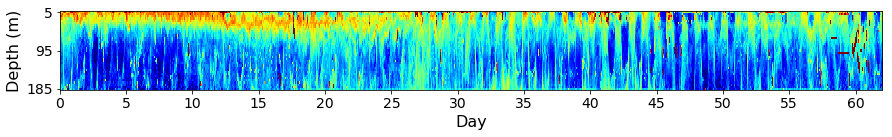

In [454]:
f = 1
fig = plt.figure(figsize=(12.5,2))
plt.imshow(MVBS_raw[f,37:0:-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Raw data, 120 kHz', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_original_MVBS_120kHz.png'),dpi=150)

### PCP-cleaned MVBS at 120 kHz

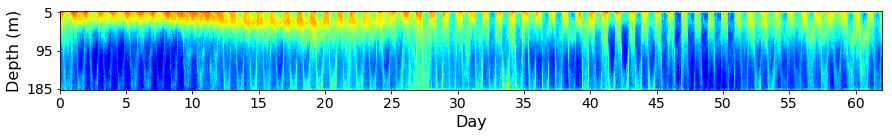

In [455]:
f = 1
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Data, 120 kHz', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_PCPcleaned_MVBS_120kHz.png'),dpi=150)

### Reconstruction from each component

In [456]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [457]:
kr_nn_cube_all = khatri_rao((factors_kruskal_nonneg_3[0],
                             factors_kruskal_nonneg_3[1],
                             factors_kruskal_nonneg_3[2]))

In [458]:
kr_nn_cube_all.shape

(165168, 3)

In [459]:
3*62*37*24

165168

In [460]:
kr_nn_cube_all_fac = [kr_nn_cube_all[:,comp].reshape(L_sep_reduce.shape) for comp in range(3)]

In [461]:
kr_nn_cube_all_fac[0].shape

(3, 62, 37, 24)

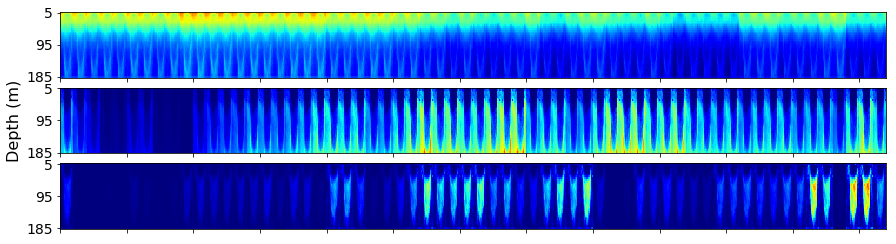

In [462]:
# fig,ax = plt.subplots(3,1,figsize=(13.5,5),sharex=True)
fig,ax = plt.subplots(3,1,figsize=(14.8,4),sharex=True)
plt.subplots_adjust(hspace=0.15)
for fac in range(3):
    zmax = kr_nn_cube_all_fac[fac][1,:,:,:].max()
    ax[fac].imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][1,:,:,:].squeeze()[:,::-1,:]),mode=1),
                   aspect='auto',cmap='jet',vmax=zmax*1.2)
    ax[fac].set_xticks(np.arange(0,24*62,24*5))
#     ax[fac].set_xticklabels(np.arange(0,62,5),fontsize=14)
#     ax[fac].set_xticks([])
    ax[fac].set_xticklabels('')
    ax[fac].set_yticks(np.arange(0,37,18))
    ax[fac].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size,fontsize=14) 
    if fac==1:
        ax[fac].set_ylabel('Depth (m)', fontsize=16)
#     if fac==2:
#         ax[fac].set_xlabel('Day', fontsize=16)
#     ax[fac].set_title('Component %d, 120 kHz' % fac, fontsize=16)
# plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_components_120kHz.png'),dpi=150)

### Summation using components at 120 kHz

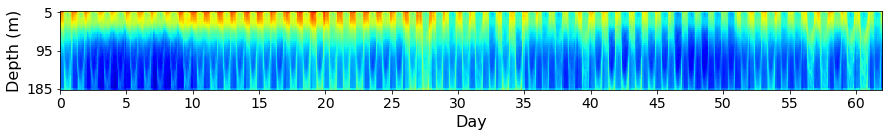

In [463]:
f = 1
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[f,:,:].reshape((62,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*24,24*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Reconstruction, 120 kHz', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_reconstruction_120kHz.png'),dpi=150)

## Reconstructing data at 38 kHz

### Raw MVBS at 38 kHz

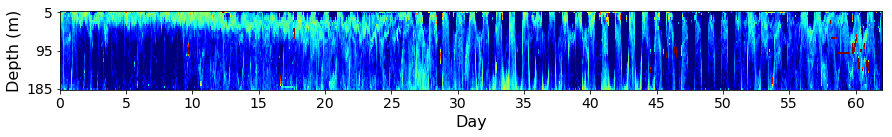

In [464]:
f = 0
fig = plt.figure(figsize=(12.5,2))
plt.imshow(MVBS_raw[f,37:0:-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Raw data, 120 kHz', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_original_MVBS_38kHz.png'),dpi=150)

### PCP-cleaned MVBS at 38 kHz

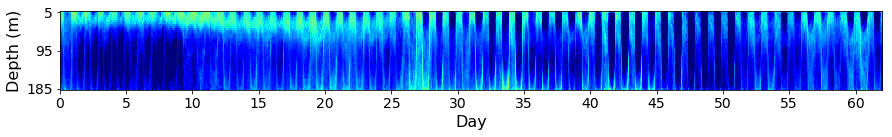

In [465]:
f = 0
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*144,144*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Data, 120 kHz', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_PCPcleaned_MVBS_38kHz.png'),dpi=150)

### Reconstruction from each component

In [466]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [467]:
kr_nn_cube_all = khatri_rao((factors_kruskal_nonneg_3[0],
                             factors_kruskal_nonneg_3[1],
                             factors_kruskal_nonneg_3[2]))

In [468]:
kr_nn_cube_all.shape

(165168, 3)

In [469]:
3*62*37*24

165168

In [470]:
kr_nn_cube_all_fac = [kr_nn_cube_all[:,comp].reshape(L_sep_reduce.shape) for comp in range(3)]

In [471]:
kr_nn_cube_all_fac[0].shape

(3, 62, 37, 24)

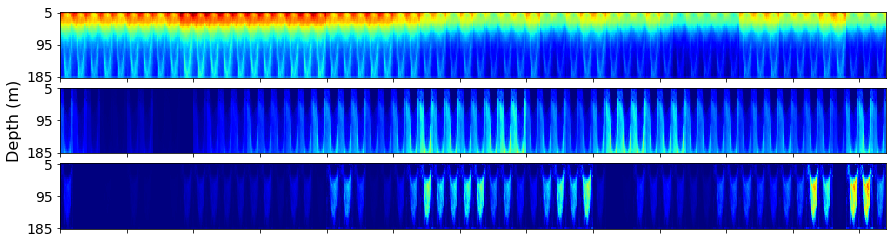

In [472]:
# fig,ax = plt.subplots(3,1,figsize=(13.5,5),sharex=True)
fig,ax = plt.subplots(3,1,figsize=(14.8,4),sharex=True)
plt.subplots_adjust(hspace=0.15)
for fac in range(3):
    zmax = kr_nn_cube_all_fac[fac][0,:,:,:].max()
    ax[fac].imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][1,:,:,:].squeeze()[:,::-1,:]),mode=1),
                   aspect='auto',cmap='jet',vmax=zmax*1.5)
    ax[fac].set_xticks(np.arange(0,24*62,24*5))
#     ax[fac].set_xticklabels(np.arange(0,62,5),fontsize=14)
#     ax[fac].set_xticks([])
    ax[fac].set_xticklabels('')
    ax[fac].set_yticks(np.arange(0,37,18))
    ax[fac].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size,fontsize=14) 
    if fac==1:
        ax[fac].set_ylabel('Depth (m)', fontsize=16)
#     if fac==2:
#         ax[fac].set_xlabel('Day', fontsize=16)
#     ax[fac].set_title('Component %d, 120 kHz' % fac, fontsize=16)
# plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_components_38kHz.png'),dpi=150)

### Summation using components at 120 kHz

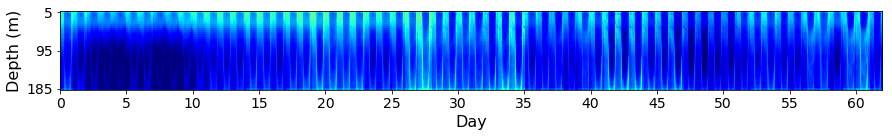

In [507]:
f = 0
fig = plt.figure(figsize=(12.5,2))
plt.imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[f,:,:].reshape((62,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
           aspect='auto', vmin=-80, vmax=-40, cmap='jet')
plt.xticks(range(0,65*24,24*5),range(0,65,5),fontsize=14)
plt.yticks(range(0,37,18),(np.arange(0,37,18)+1)*depth_bin_size,fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
# plt.title('Reconstruction, 120 kHz', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','echogram_reconstruction_38kHz.png'),dpi=150)

## Check variation over days

In [474]:
from scipy.spatial.distance import pdist, squareform

In [475]:
D = pdist(k_norm, 'euclidean')

In [476]:
D_square = squareform(D)

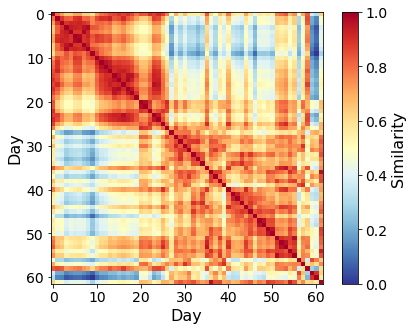

In [510]:
fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
plt.imshow(1-D_square/D_square.max(),cmap='RdYlBu_r')
plt.xticks(np.arange(0,62,10),fontsize=14)
plt.yticks(np.arange(0,62,10),fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Day',fontsize=16)
# cbar = plt.colorbar()
cbaxes = fig.add_axes([0.8, 0.125, 0.03, 0.755]) 
cbar = plt.colorbar(cax = cbaxes)  
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_ylabel('Similarity', rotation=90, fontsize=16)
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','similarity.png'),dpi=150)

## Clustering to check the similarity grouping

In [511]:
from scipy.cluster import hierarchy

In [512]:
Z = hierarchy.linkage(k_norm, 'ward')
Z_optimal = hierarchy.optimal_leaf_ordering(Z,k_norm)

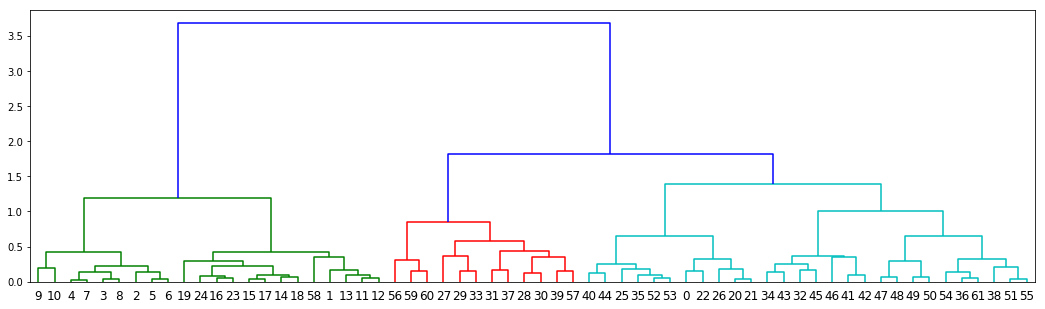

In [513]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(Z,
                          leaf_rotation=0,
                          leaf_font_size=12,
                          color_threshold=1.5)
plt.show()

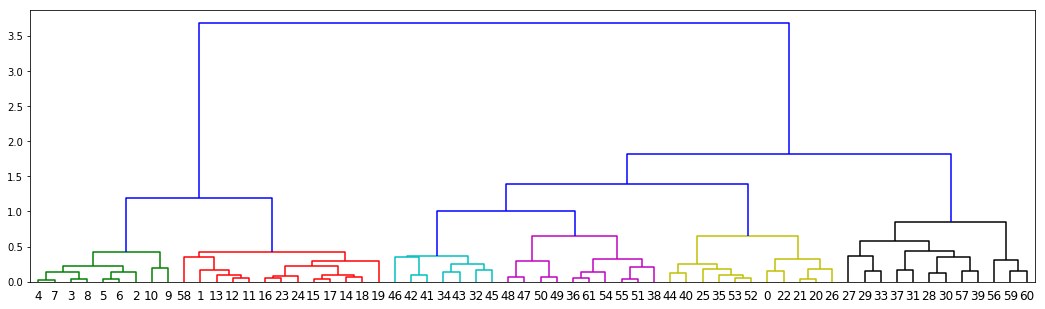

In [514]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(Z_optimal,
                          leaf_rotation=0,
                          leaf_font_size=12,
                          color_threshold=1)
plt.show()

In [515]:
leaf_idx = hierarchy.leaves_list(Z_optimal)
leaf_idx

array([ 4,  7,  3,  8,  5,  6,  2, 10,  9, 58,  1, 13, 12, 11, 16, 23, 24,
       15, 17, 14, 18, 19, 46, 42, 41, 34, 43, 32, 45, 48, 47, 50, 49, 36,
       61, 54, 55, 51, 38, 44, 40, 25, 35, 53, 52,  0, 22, 21, 20, 26, 27,
       29, 33, 37, 31, 28, 30, 57, 39, 56, 59, 60], dtype=int32)

In [516]:
max_d = 1
clusters = hierarchy.fcluster(Z_optimal, max_d, criterion='distance')

cc = []
c_start = 0
c_end = 0
for c in np.arange(clusters.max())+1:
    c_idx = np.argwhere(clusters==c)
    print((c-1,c_start, c_start+len(c_idx)-1, np.array(c_idx).T))
    c_start = c_start+len(c_idx)
    cc.append(c_idx)

(0, 0, 8, array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10]]))
(1, 9, 21, array([[ 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 58]]))
(2, 22, 28, array([[32, 34, 41, 42, 43, 45, 46]]))
(3, 29, 38, array([[36, 38, 47, 48, 49, 50, 51, 54, 55, 61]]))
(4, 39, 49, array([[ 0, 20, 21, 22, 25, 26, 35, 40, 44, 52, 53]]))
(5, 50, 61, array([[27, 28, 29, 30, 31, 33, 37, 39, 56, 57, 59, 60]]))


In [517]:
leaf_idx_new = [cc[0],cc[1],cc[4],cc[3][::-1],cc[2],cc[5]]
leaf_idx_new = np.vstack(leaf_idx_new).squeeze()

In [518]:
D = pdist(k_norm, 'euclidean')
Dc = pdist(k_norm[leaf_idx], 'euclidean')
Dc_new = pdist(k_norm[leaf_idx_new], 'euclidean')

D_square = squareform(D)
Dc_square = squareform(Dc)
Dc_new_square = squareform(Dc_new)

Below plot the similarity matrix (1-normalized distance):

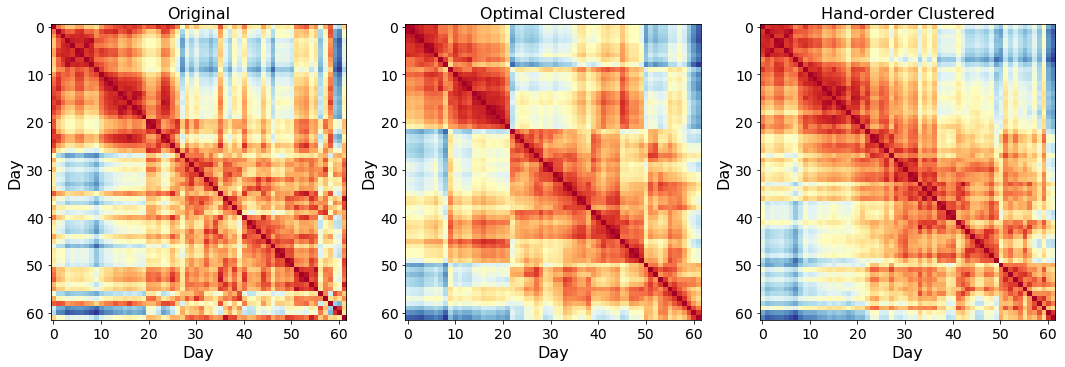

In [529]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
for panel in range(3):
    if panel==0:
        ax[panel].imshow(1-D_square/D_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Original',fontsize=16)
    elif panel==1:
        ax[panel].imshow(1-Dc_square/Dc_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Optimal Clustered',fontsize=16)        
    else:
        ax[panel].imshow(1-Dc_new_square/Dc_new_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Hand-order Clustered',fontsize=16)        
    ax[panel].set_xlabel('Day',fontsize=16)
    ax[panel].set_ylabel('Day',fontsize=16)
    plt.setp(ax[panel].get_xticklabels(),fontsize=14)
    plt.setp(ax[panel].get_yticklabels(),fontsize=14)
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','similarity_clustered.png'),dpi=150)
plt.show()

Check how the clustered days relate to the original day sequence:

In [523]:
idx_link = np.vstack((np.arange(62),leaf_idx_new))
idx_link

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10,  1, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 23, 24, 58,  0, 20, 21, 22, 25, 26, 35, 40, 44, 52,
        53, 61, 55, 54, 51, 50, 49, 48, 47, 38, 36, 32, 34, 41, 42, 43,
        45, 46, 27, 28, 29, 30, 31, 33, 37, 39, 56, 57, 59, 60]])

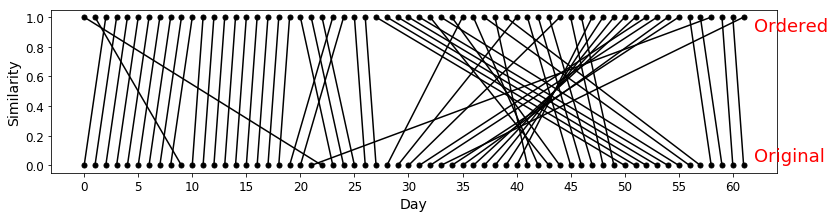

In [528]:
plt.figure(figsize=(13,3))
plt.plot(idx_link,[0,1],'k.-',markersize=10)
plt.xticks(np.arange(0,62,5),fontsize=12)
plt.xlabel('Day',fontsize=14)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.ylabel('Similarity',fontsize=14)
plt.text(62,0,'Original',{'fontsize':18,'va':'bottom','color':'r'})
plt.text(62,1,'Ordered',{'fontsize':18,'va':'top','color':'r'})
plt.savefig(os.path.join('/home/wu-jung/code_git/ooi_sonar/tensor','similarity_clustered_link.png'),dpi=150)
plt.show()